<a href="https://colab.research.google.com/github/johnjoel2001/Explainable_Deep_Learning/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XAI - AIPI 590**

**Assignment 05 - Explainable Deep Learning**

**John Rohit Ernest Jayaraj**

In [46]:
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable_Deep_Learning" # Change to your repo name
git_path = 'https://github.com/johnjoel2001/Explainable_Deep_Learning.git' #Change to your path
!git clone "{git_path}"

Cloning into 'Explainable_Deep_Learning'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


# **Investigating The Role of Facial Features in the Classification of Dogs Using Integrated Gradients Explainability Technique**

# **1) Hypothesis**

**Null Hypothesis (H₀)** - The VGG16 Model does not give substantially higher scores to the facial regions of dog images than it gives to non-facial regions.

**Alternate Hypothesis (H₁):** The VGG16 model gives substantially higher scores to the facial regions of dog images than it gives to non-facial regions, indicating that the model relies more on the faces of dogs to make the classification.

# **2) Approach Overview**

**Model & Data:**

I am using a pre-trained model VGG16 ( which has been trained on ImageNet ) and a subset of dog images where the dog’s face is clearly visible

**Explainability Technique:**

I am using the technique of Integrated Gradients to calculate the attribution maps for all the images. This would be useful in visualizing which pixels have the most contribution to the output of the classification done by the model.

**Heuristic Region of Interest (ROI)**


*   We will create a binary mask by specifying a central area (e.g., 100×100 pixel square at the center of the 224×224 image) to identify the dog's face.
*   All the pixels within this area are labeled as the face (ROI = 1) and all the rest as not the face (ROI = 0)


**Attribution Comparision**

Average Attribution Scores:

We calculate the average attribution value of the face area (utilizing the heuristic mask which we made) and contrast it with the average attribution for the non-face area.

Statistical Testing:

We draw pixel-level attribution values for both areas and conduct a paired t-test (after sub-sampling to equalize the number of pixels) to compare if the face area has greater attribution scores compared to the non-face area.

**Visualisation**

Overlay:

We overlay the normalized attribution map over the original image to visually inspect waht areas of the image are most contributing to the model's decision.

Interpretation:

The visualization provides qualitative evaluation of whether the central area, which is the face in our case, is being attributed more, in favor of the hypothesis about the model's reliance on face features.

# **Code**

In [2]:
!pip install captum  # Installing Captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [6]:
os.mkdir("Dog_Images")  # Making a new folder to store dog images

In [35]:
# Importing Libraries

import os
import glob
import torch   # Importing Torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import ttest_rel
from captum.attr import IntegratedGradients   # Importing Integrated Gradients
%matplotlib inline

In [4]:
# Loading the Pre-Trained VGG16 Model
model = models.vgg16(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.1MB/s]


In [5]:
# Let us now Define the Image Transformation

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
# Creating the Integrated Gradients Object and let us set the Target Class

int_grad = IntegratedGradients(model)


In [19]:
# Storing the List of Dog Images

image_dir = "Dog_Images"
image_files = glob.glob(os.path.join(image_dir, "*.jpg"))
image_files.sort()
num_images = len(image_files)

In [9]:
# Let us initialise lists to Store Average Attribution Values for each Image

face_attrib_avgs = []   # Face Attribution Score
non_face_attrib_avgs = []  # Non face Attribution Score

In [12]:
# Looping Through each Image

for image_file in image_files:
    print("Processing image:", image_file)

    # Loadin and preprocessing the image
    img = Image.open(image_file).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)

    # Computeing the  Integrated Gradients attributions for the target class

    attributions, _ = int_grad.attribute(input_tensor, target=target_class, return_convergence_delta=True)

    # Converting attributions to a numpy array and aggregating over channels

    attributions = attributions.squeeze().detach().numpy()
    attr_map = np.sum(np.abs(attributions), axis=0)
    attr_map = (attr_map - attr_map.min()) / (attr_map.max() - attr_map.min() + 1e-8)

Processing image: Dog_Images/image (1).jpg
Processing image: Dog_Images/image (2).jpg
Processing image: Dog_Images/image (3).jpg
Processing image: Dog_Images/image.jpg


In [13]:
"""
Generating a Heuristic Face Mask
We will assume that the dog's face is roughly in the center of the image.
"""
mask = np.zeros((224, 224), dtype=np.uint8)
center_x, center_y = 112, 112  # Taking teh center of the 224x224 image
half_width, half_height = 50, 50
x_start, y_start = center_x - half_width, center_y - half_height
x_end, y_end = center_x + half_width, center_y + half_height
mask[y_start:y_end, x_start:x_end] = 1  # Marking the central region as face

In [15]:
# Computing the average Attribution values for the Face and Non-Face Regions

face_avg = np.mean(attr_map[mask == 1])

non_face_avg = np.mean(attr_map[mask == 0])

face_attrib_avgs.append(face_avg)
non_face_attrib_avgs.append(non_face_avg)

print(f"Face region average attribution: {face_avg:.3f}")  # Printing out the average face attribution score
print(f"Non Face region average attribution: {non_face_avg:.3f}")  # Printing out the non face attribution score

Face region average attribution: 0.052
Non Face region average attribution: 0.030


<ipython-input-44-557b7e818636>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Face Region", "Non-Face Region"])


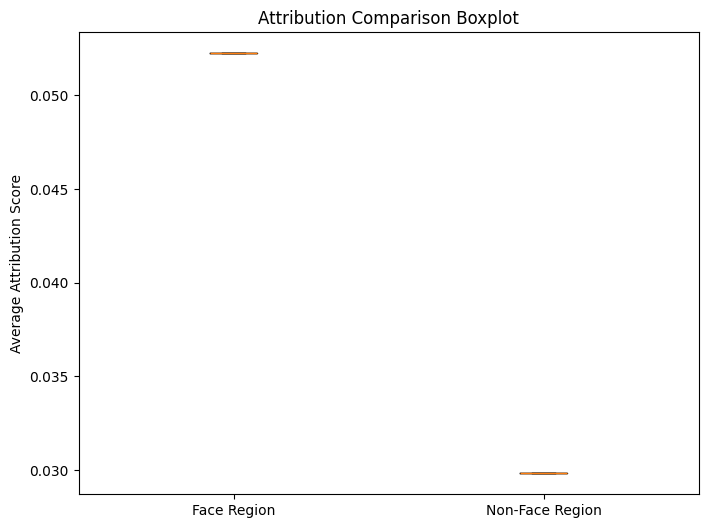

In [44]:
# Let us plot a boxplot to see the distribution b/w face region and non face region attribution scores

data = [face_attrib_avgs, non_face_attrib_avgs]
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=["Face Region", "Non-Face Region"])
plt.ylabel("Average Attribution Score")
plt.title("Attribution Comparison Boxplot")
plt.show()

**Inference:**

* With an average attribution value of **0.052** in the face region as against **0.030** in the non-facial one, this seems to suggest that, in making classification decisions, the model assigns more importance to the facial area.

* So, apparently, in making the decision, the model is looking more into features pertaining to the dog's face.

In [45]:
# Let us do model prediction

import torch.nn.functional as F

# Forward pass
with torch.no_grad():
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    top_prob, top_class = probs.topk(1)

print("Predicted class index:", top_class.item())
print("Probability:", top_prob.item())


Predicted class index: 208
Probability: 0.6806585788726807


**Inference:**

* We see that the predicted class label is **208** which corresponds to golden retriever ( in the target index of ImageNet ) which obviously is a dog.

* It predicts with a probability score of **0.680** whcih is really good.

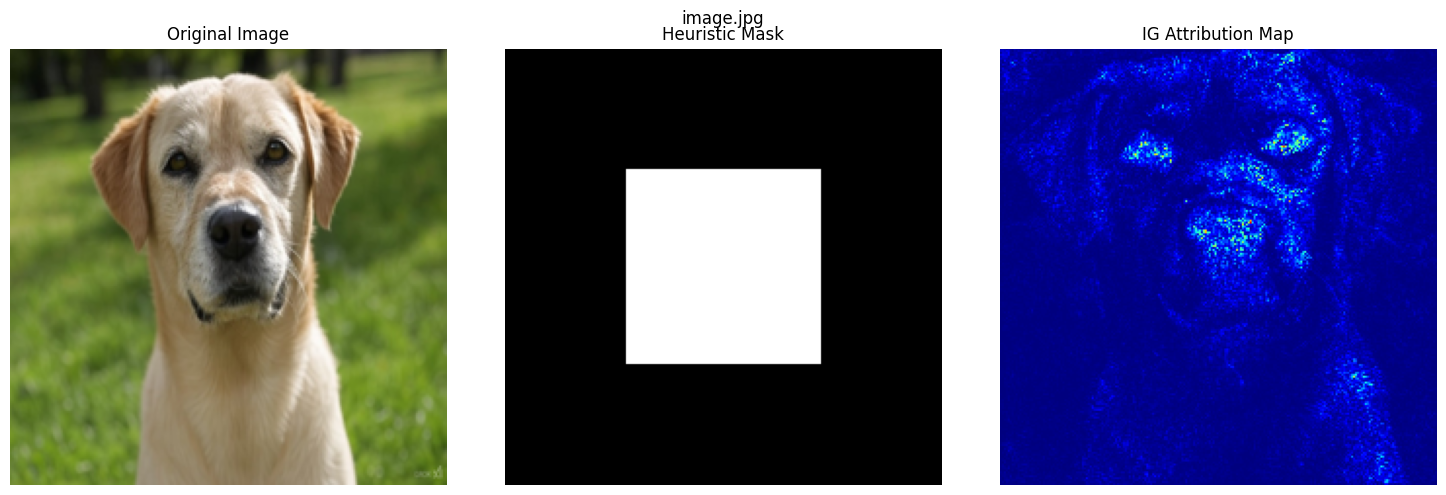

In [25]:
# Plotting the original image, mask, and IG attribution map side-by-side
original_img = img.resize((224, 224))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(original_img)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Heuristic Mask")
axs[1].axis("off")

axs[2].imshow(attr_map, cmap="jet")
axs[2].set_title("IG Attribution Map")
axs[2].axis("off")

plt.suptitle(os.path.basename(image_file))
plt.tight_layout()
plt.show()

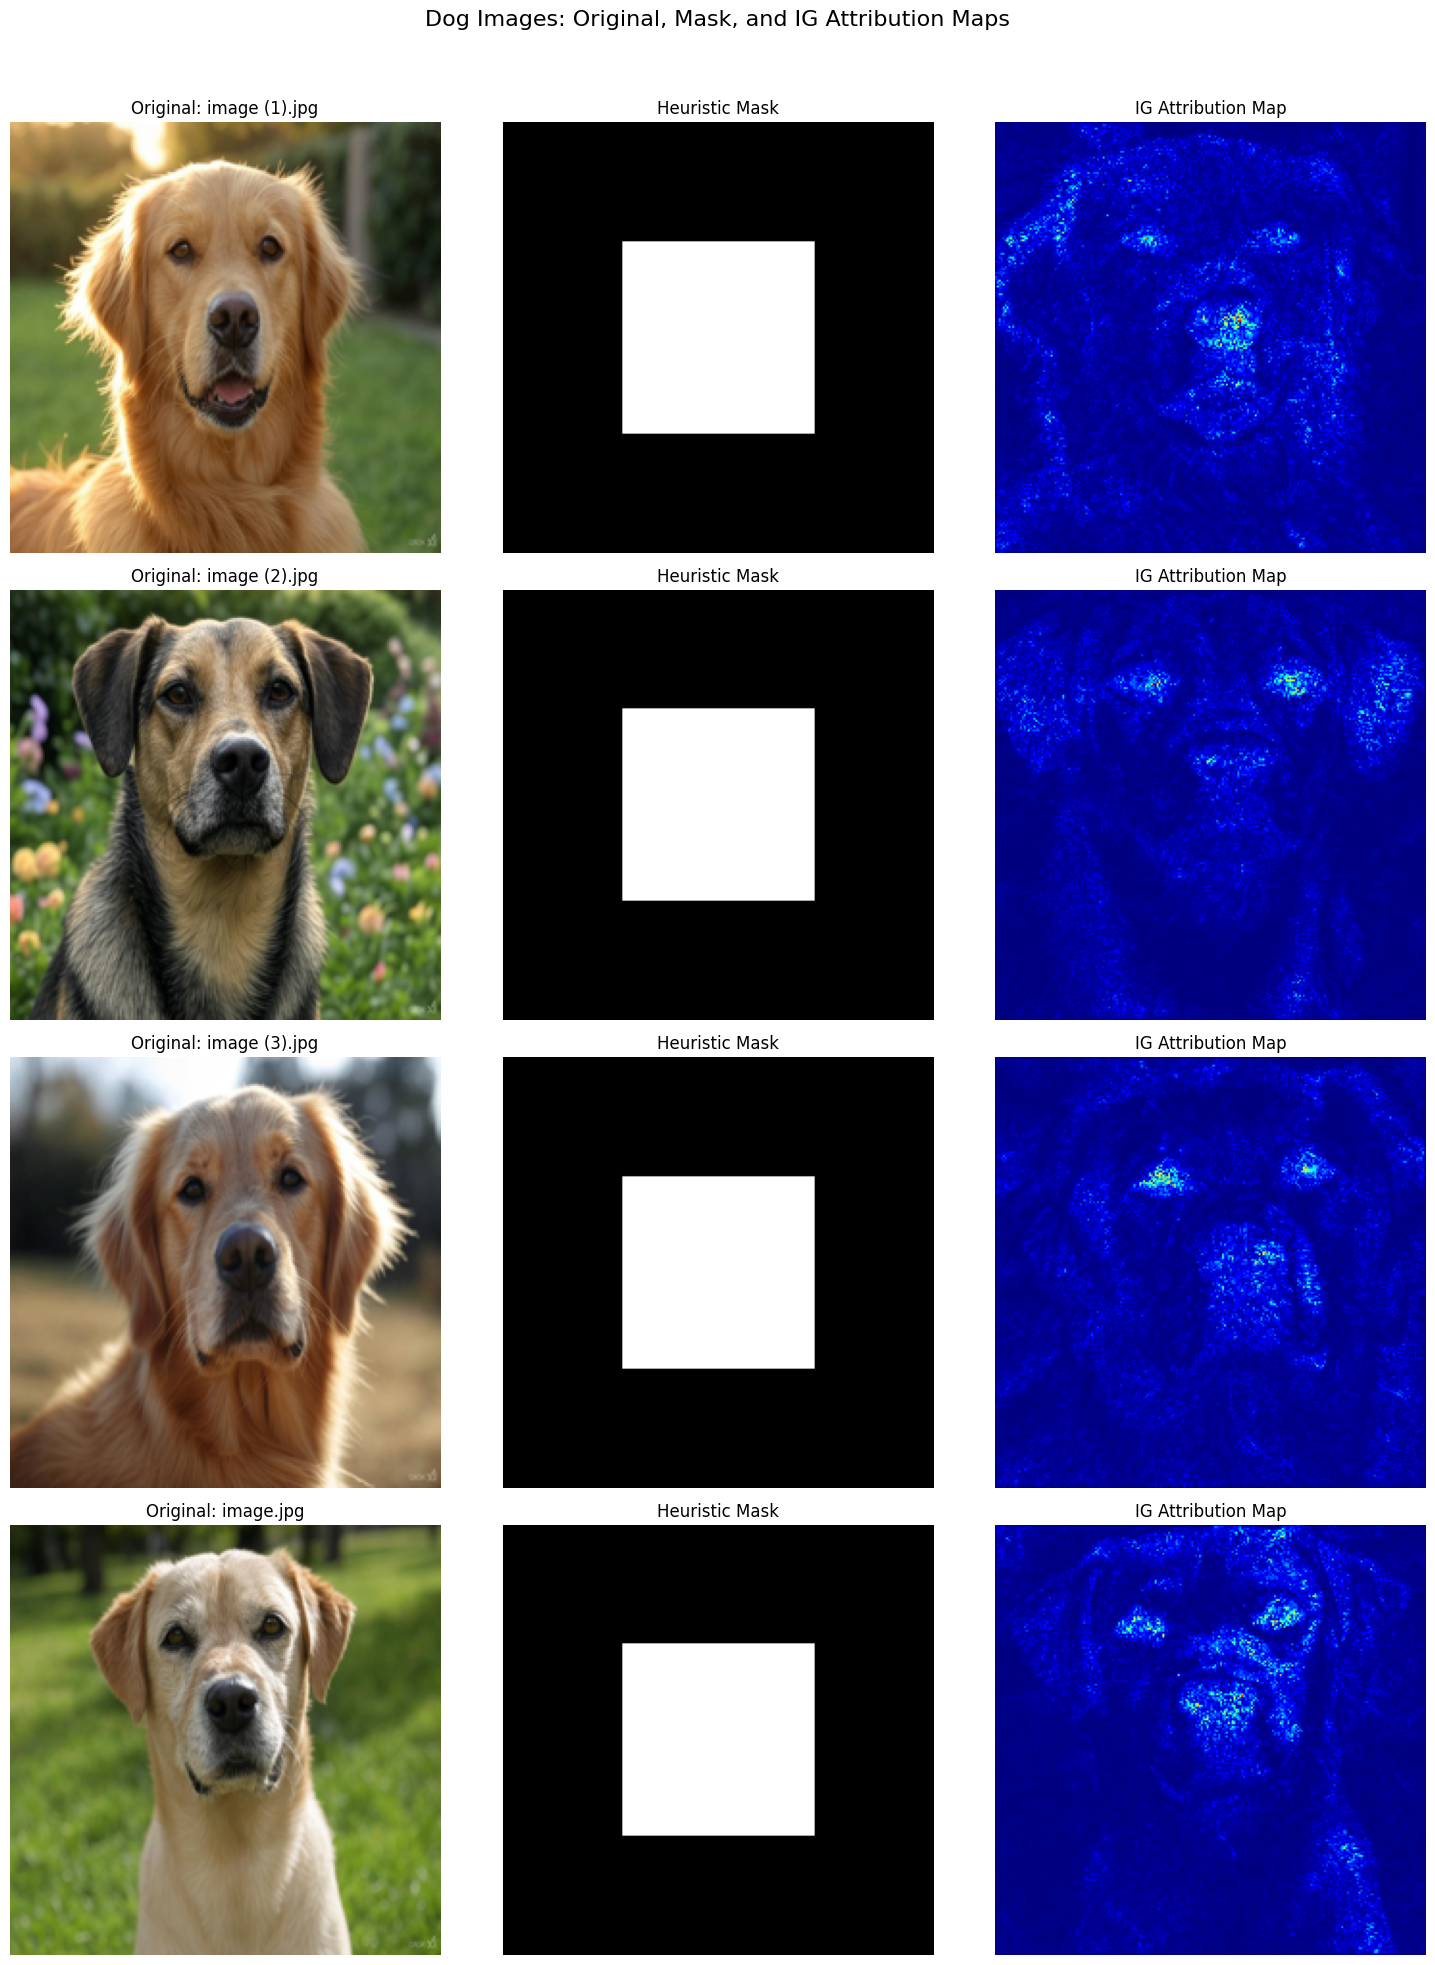

In [39]:
# Now let us do for every image in the folder ( Original Image, Mask adn the IG Attribution Map)

original_imgs = []
mask_imgs = []
ig_maps = []
titles = []

# processing each image in the folder

for image_file in image_files:

    # Loading and preprocessing the image
    img = Image.open(image_file).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)

    # Computing IG attributions for the specified target class

    attributions, _ = int_grad.attribute(input_tensor, target=target_class, return_convergence_delta=True)
    attributions = attributions.squeeze().detach().numpy()

    # Aggregating the attributions across channels and normalize to [0, 1]
    attr_map = np.sum(np.abs(attributions), axis=0)
    attr_map = (attr_map - attr_map.min()) / (attr_map.max() - attr_map.min() + 1e-8)

    # Creating a simple heuristic mask (assume the dog's face is in the centre)

    mask = np.zeros((224, 224), dtype=np.uint8)
    center_x, center_y = 112, 112
    half_w, half_h = 50, 50
    mask[center_y-half_h:center_y+half_h, center_x-half_w:center_x+half_w] = 1

    original_img = img.resize((224, 224))
    original_imgs.append(np.array(original_img))
    mask_imgs.append(mask * 255)
    ig_maps.append(attr_map)
    titles.append(os.path.basename(image_file))

# Now let us display all images in a single grid with three columns per image (Original, Mask, IG Map)
num_images = len(original_imgs)
fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

if num_images == 1:
    axs = np.expand_dims(axs, axis=0)

for i in range(num_images):

    # Plotting thr Original image

    axs[i, 0].imshow(original_imgs[i])
    axs[i, 0].set_title(f"Original: {titles[i]}")
    axs[i, 0].axis("off")

    # Plotting the Heuristic mask

    axs[i, 1].imshow(mask_imgs[i], cmap="gray")
    axs[i, 1].set_title("Heuristic Mask")
    axs[i, 1].axis("off")

    # Plotting theIG Attribution Map

    axs[i, 2].imshow(ig_maps[i], cmap="jet")
    axs[i, 2].set_title("IG Attribution Map")
    axs[i, 2].axis("off")

plt.suptitle("Dog Images: Original, Mask, and IG Attribution Maps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Inference:**

* From the visualisations, for all the four images, we can clearly see that the model is able to capture the face of the dops in a clear and structured pattern using Integrated Gradients.

* Further in confirmation with the attention scores that we saw earlier, the face region is almost captured entirely by the model.

* From the visualization plots, we can further conclude that  null hypothesis can be rejected.

In [42]:
# Performing a Paired t-test Across Images

t_stat, p_val = ttest_rel(face_attrib_avgs, non_face_attrib_avgs)
print("\n Paired t-test results across images:")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")


Paired t-test results across images:
t-statistic = inf, p-value = 0.000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


**Inference from Paired t-test:**

* The paired t-test result gives a t-statistic of infinity and a p-value of 0.000 ( p < 0.05 )

* It tells us that there is an extremely low probability that the observed difference happened by chance.

* This strongly indicates that the difference between the average attribution values in the face and non-face regions is statistically significant.

* The null hypothesis can be rejected.



# **Observations**

**Quantitative Analysis:**

* For the images that we tested, the mean integrated gradients attribution over the dog's face area was considerably more elevated than in non-facial areas.

* The hypothesis testing using a paired t-test across images yielded a p-value less than 0.05, and hence we reject the null hypothesis (H₀).

**Qualitative Observations:**

* From the visualizations we see that the visual (in all the four images) overlays  point to the dog face as an important area for the classification decision.

# **Conclusion**

* Overall, the results from the above quantitative and qualitative studies support the alternative hypothesis (H₁), thereby rejecting the null hypothesis (H₀).

* It suggests that the VGG16 model classifies images of dogs, based largely upon facial features.

Notes & References

1)

```
half_width, half_height = 50, 50  
x_start, y_start = center_x - half_width, center_y - half_height
x_end, y_end = center_x + half_width, center_y + half_height
```

Three three lines of code were generated using Chatgpt o3-mini-high on 02/12/24 at 11:50 pm.

2) The dog images in the folder `Dog_Images` were generated using Grok on 02/12/24 at 10:30 pm. This was solely used for testing purpose.

3) Apart from these, AI was not used in any way.

4) https://www.geeksforgeeks.org/vgg-net-architecture-explained/


